### Testing basic convolution, fft, scoring metric for subsequence existence

In [1]:
from scipy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
from ont_fast5_api.fast5_interface import get_fast5_file

### Data extraction from f5

In [3]:
def get_data_from_fast5(fast5_filepath):
    data_arr = []
    read_ids = []
    with get_fast5_file(fast5_filepath, mode="r") as f5:
        for read in f5.get_reads():
            raw_data = read.get_raw_data()
            read_ids.append(read.read_id)
            data_arr.append(raw_data)
    return read_ids, data_arr

In [4]:
f5_filepath = r"data\FAW71953_6c8b1e8d_944d09f0_2.fast5"
_, data_arr = get_data_from_fast5(f5_filepath)

### Nanopore signal cleaning

In [5]:
from scipy.signal import butter, filtfilt, savgol_filter

def clean_signal(signal, fs=4000, cutoff=2):
    b, a = butter(2, cutoff/(0.5*fs), btype='high') # high pass filter
    signal = filtfilt(b, a, signal) # digital filter
    signal = savgol_filter(signal, window_length=11, polyorder=3) # smoothing
    return(signal - np.mean(signal)) / np.std(signal) # norming


### FFT cross-correlation

In [6]:
import numpy as np

def cross_correlation_fft(x, y):
    # Ensure equal length
    n = len(x) + len(y) - 1
    n_padded = 1 << (n - 1).bit_length()  # next power of 2 for efficiency
    
    # FFT of both signals
    X = np.fft.fft(x, n_padded)
    Y = np.fft.fft(y, n_padded)
    
    # Multiply X with conjugate of Y
    corr = np.fft.ifft(X * np.conj(Y))
    
    # Only the real part is meaningful
    return np.real(corr)


### Helixworks based analysis

In [52]:
import pandas as pd

In [53]:
def reverse_complement(dna):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in reversed(dna))

In [9]:
# getting rc version of the spacers
spacers = [
'TTGGATAAGAGGCGTTGGGAGTAAA',
'GATTAAGAGGCGTGGATGAAAGTAT',
'GAAGAGTGCGTGTGAGATAGATAGG',
'TGCGGGTAGGTGAAAGTAGGATGTG',
'GTGGAGAAGTGAGTAGGAAAGTAAG',
'GTGGTAGTAAGTAGAAGTGTGTGAG',
'GCGAATGAAGGGTAGTATATAGGAG',
'TTTGTGCGATGGTGGGATGGAAGAA',
'GCGGGGATAAAGGTAGAAAAGGTAA',
'AGGGATGGAGCTGGGTTGTATGTAA',
'ATAGTGTAGTTGGGATGGGCAGAGA'
]

rev_spacers = [reverse_complement(i) for i in spacers]

In [10]:
len(spacers[0])

25

In [11]:
rev_spacers

['TTTACTCCCAACGCCTCTTATCCAA',
 'ATACTTTCATCCACGCCTCTTAATC',
 'CCTATCTATCTCACACGCACTCTTC',
 'CACATCCTACTTTCACCTACCCGCA',
 'CTTACTTTCCTACTCACTTCTCCAC',
 'CTCACACACTTCTACTTACTACCAC',
 'CTCCTATATACTACCCTTCATTCGC',
 'TTCTTCCATCCCACCATCGCACAAA',
 'TTACCTTTTCTACCTTTATCCCCGC',
 'TTACATACAACCCAGCTCCATCCCT',
 'TCTCTGCCCATCCCAACTACACTAT']

In [54]:
library_df = pd.read_csv("data\completed_library.csv")

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Parv\AppData\Local\Temp\ipykernel_31796\1094912200.py:1: SyntaxWarning: invalid escape sequence '\c'
  library_df = pd.read_csv("data\completed_library.csv")


In [70]:
seqs = library_df['Sequence'].tolist()

In [72]:
rc_seqs = [reverse_complement(i) for i in seqs]

In [73]:
tseqs = seqs + rc_seqs

In [79]:
def write_fasta(strands, filepath=r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\sample.fa.txt"):
    counter = 3793
    with open(filepath, 'w') as f:
        for strand in strands:
            f.write(f'>>seq_{counter} {len(strand)}bp\n')
            f.write(strand)
            f.write('\n\n')
            counter += 1

In [80]:
write_fasta(tseqs)

In [51]:
seqs

NameError: name 'seqs' is not defined

### Spacer positions within full motif choices

In [199]:
for ptr, seq in enumerate(seqs[:-1]):
    if ptr == 0:
        cycle_position = 0
    else:
        cycle_position = int((ptr - 1) / 8)

    print(seq)
    print(rev_spacers[cycle_position][12:] + "A"*25 + rev_spacers[cycle_position+1][:12])
    print()
    #print(rev_spacers[cycle_position][12:] + "A"*25 + rev_spacers[cycle_position+1][13:])
    """
    for i, j in zip(rev_spacers, spacers):
        if i[12:] in seq:
            print(seq)
            print(i[12:] + "A"*25 + i[:12])
            print(i[:12])
            print(j)
        #if j[12:] in seq:
        #    print(j)
    """

ACTTACCCGCTACTTTCATCACTAATTTACTCCCAAC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAAAACAACATCAATCCTACATCGCCTAATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAAATATACCTCGCCTCATCTCAATCAAATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAATTTCACTTCTTATCCGCCTCACCTAATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAACACCTTCACCTTACCTACTCAATTCATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAACAACCCTCTATCCGCCTCTCCACTAATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAAAACCCATCACTTACCTCTCTTAACAATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAACCATCCATATCATTTTCTCCTTACCATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

GCCTCTTATCCAACCACATCTACCCTTCCACTCTATCAATACTTTCATCC
GCCTCTTATCCAAAAAAAAAAAAAAAAAAAAAAAAAAAATACTTTCATCC

ACGCCTCTTAATCAACAACATCAATCCTACATCGCCTACCTATCTATCTC
ACGCCTCTTAATCAAAAAAAAAAAAAAAAAAAAAA

### Testing spacer finding using DSP

In [85]:
_, motif_data = get_data_from_fast5(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\slow5tools-v1.1.0\testing.fast5")

In [82]:
len(data)

164

In [ ]:

def cross_correlation_fft(x, y):
    # Ensure equal length
    n = len(x) + len(y) - 1
    n_padded = 1 << (n - 1).bit_length()  # next power of 2 for efficiency
    
    # FFT of both signals
    X = np.fft.fft(x, n_padded)
    Y = np.fft.fft(y, n_padded)
    
    # Multiply X with conjugate of Y
    corr = np.fft.ifft(X * np.conj(Y))
    
    # Only the real part is meaningful
    return np.real(corr)

In [97]:
[len(i) for i in motif_data]

[288,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 297,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 297,
 288,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405,
 405]

In [100]:
def create_motif_payload_sequence(data_squiggle):
    motif_signal_positions = []
    max_match_scores = []

    n_padded = len(data_squiggle) + 405

    get_fft = lambda x: np.fft.fft(clean_signal(x), n_padded)

    data_fft = get_fft(data_squiggle)
    fft_motifs = [get_fft(motif) for motif in motif_data]

    for motif_index, motif in enumerate(fft_motifs):
        corr = np.real(np.fft.ifft(
            data_fft * np.conj(motif)))

        best_position = np.argmax(corr)
        best_match_score = np.max(corr)
        
        motif_signal_positions.append(best_position)
        max_match_scores.append(best_match_score)

    return motif_signal_positions, max_match_scores

In [95]:
data_arr[0]

array([589, 522, 513, ..., 600, 587, 613], dtype=int16)

In [ ]:
motif_signal_positions, max_match_scores = create_motif_payload_sequence(data_arr[0])

In [124]:
extracted_motif_positions = [i for i, j in zip(motif_signal_positions, max_match_scores) if j > 200]
chosen_motifs = [i+1 for i, j in enumerate(max_match_scores) if j > 250]

In [127]:
np.mean(max_match_scores)

np.float64(220.9709502401191)

In [128]:
np.std(max_match_scores)

np.float64(37.39114983763821)

In [125]:
np.array(extracted_motif_positions) / 8

array([530.75 , 348.625,  73.625,  61.25 , 348.75 ,  73.625, 529.375,
        73.875,  65.375,  73.875,  74.125,  74.   , 529.75 , 529.75 ,
       530.375, 530.   , 529.375, 533.125, 530.5  , 530.5  , 530.125,
        69.375,  73.5  ,  69.375, 559.625, 343.   , 529.5  , 340.   ,
       554.25 , 353.   , 330.75 , 528.875, 529.75 , 529.75 , 530.   ,
       529.875, 529.75 , 530.125, 530.125, 530.   , 348.625,  73.375,
       529.625, 328.875,  64.75 , 339.625, 348.875,  73.625, 529.25 ,
        44.5  , 330.75 , 490.625, 529.375,  75.   , 339.5  ,  74.875,
        79.625, 564.5  ,  79.875,  73.75 , 339.375, 339.375, 488.   ,
       555.   , 339.5  , 560.625, 563.125,  65.75 ,  65.5  ,  73.625,
       562.125, 515.125, 532.25 , 532.75 , 532.375, 528.5  , 529.875,
       529.   , 529.625, 529.875, 529.625, 529.625, 529.75 , 528.625,
       529.75 , 529.375, 529.5  ,  65.625, 518.125, 488.   , 523.75 ,
       555.   , 339.625, 560.75 , 562.625,  65.625, 562.875, 560.375,
        73.625, 562.

In [126]:
chosen_motifs

[4,
 11,
 12,
 13,
 14,
 15,
 20,
 22,
 25,
 26,
 27,
 28,
 29,
 35,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 57,
 68,
 69,
 74,
 78,
 85,
 100,
 107,
 108,
 109,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 129,
 130,
 133,
 136]

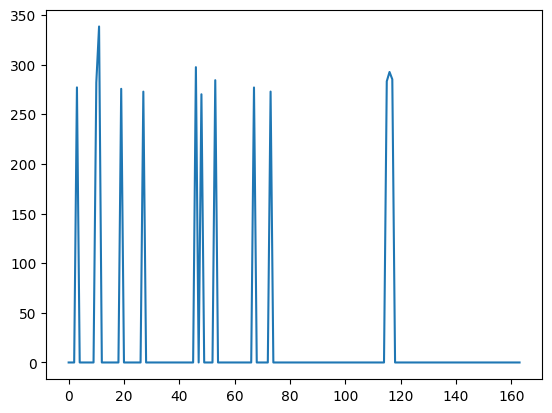

In [108]:
plt.plot([i if i > 270 else 0 for i in max_match_scores])

In [102]:
motif_signal_positions

[np.int64(856),
 np.int64(4246),
 np.int64(2789),
 np.int64(589),
 np.int64(590),
 np.int64(521),
 np.int64(490),
 np.int64(343),
 np.int64(2084),
 np.int64(2674),
 np.int64(2790),
 np.int64(589),
 np.int64(4235),
 np.int64(591),
 np.int64(523),
 np.int64(591),
 np.int64(593),
 np.int64(658),
 np.int64(592),
 np.int64(4238),
 np.int64(4238),
 np.int64(4243),
 np.int64(4240),
 np.int64(4235),
 np.int64(4265),
 np.int64(4244),
 np.int64(4244),
 np.int64(4241),
 np.int64(555),
 np.int64(588),
 np.int64(555),
 np.int64(4477),
 np.int64(540),
 np.int64(2744),
 np.int64(4236),
 np.int64(2720),
 np.int64(4434),
 np.int64(558),
 np.int64(2824),
 np.int64(2741),
 np.int64(3777),
 np.int64(357),
 np.int64(2646),
 np.int64(2719),
 np.int64(2681),
 np.int64(4231),
 np.int64(4238),
 np.int64(4238),
 np.int64(4240),
 np.int64(4239),
 np.int64(4238),
 np.int64(4241),
 np.int64(4241),
 np.int64(4240),
 np.int64(2789),
 np.int64(587),
 np.int64(4237),
 np.int64(2631),
 np.int64(518),
 np.int64(490),
 n

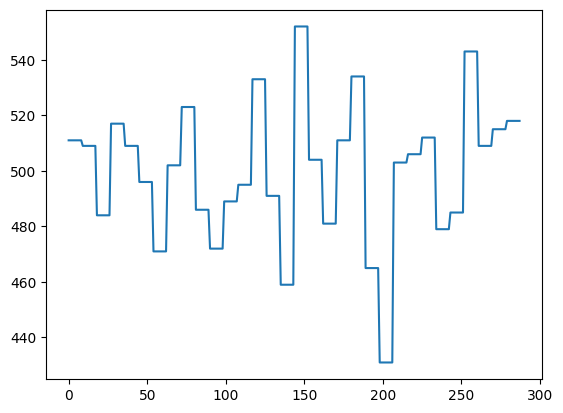

In [83]:
plt.plot(data[0])

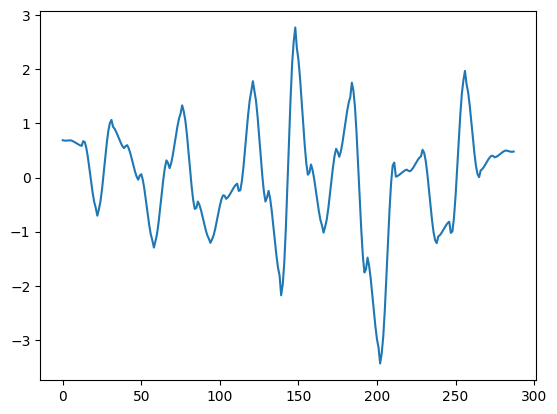

In [84]:
plt.plot(clean_signal(data[0]))

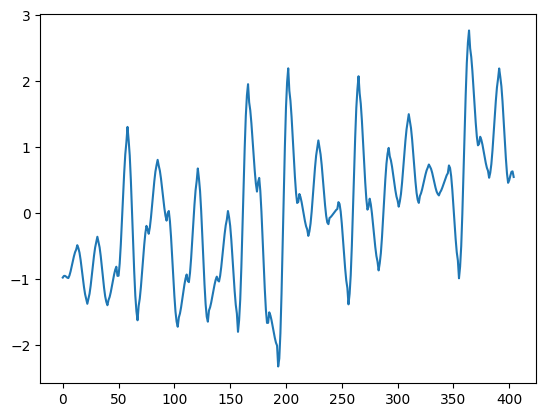

In [16]:
plt.plot(spacer_rep)

Remember strands can be reverse complemented and forward

In [26]:
from tqdm.notebook import tqdm

In [36]:
corrs = []
motif_position = []
motif_current = []
for i in tqdm(data_arr):
    corr = cross_correlation_fft(clean_signal(i), clean_signal(data[1]))
    corrs.append(corr)
    motif_position.append(np.argmax(corr)/8)
    max_current = motif_current.append(np.max(corr))

  0%|          | 0/4000 [00:00<?, ?it/s]

(array([2543., 1041.,  228.,   75.,   29.,   38.,   23.,    8.,    9.,
           6.]),
 array([ 141.34312827,  249.81534647,  358.28756468,  466.75978289,
         575.2320011 ,  683.7042193 ,  792.17643751,  900.64865572,
        1009.12087393, 1117.59309213, 1226.06531034]),
 <BarContainer object of 10 artists>)

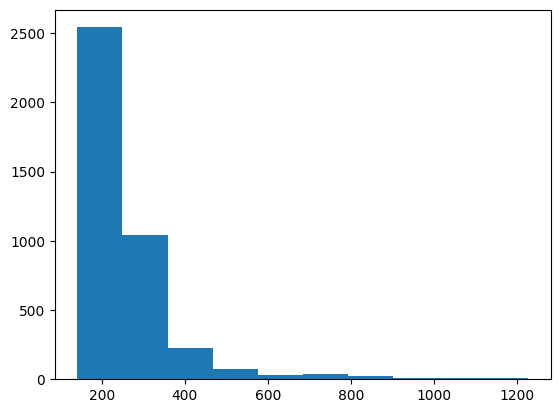

In [32]:
plt.hist(motif_current)

In [37]:
posis = [i for i, j in zip(motif_position, motif_current) if j > 300]

In [46]:
len_sum = 0

for i in data_arr:
    print(len(i))

4640
11560
4964
3875
4260
3523
6668
4734
5944
4638
4145
6115
13016
4563
5443
10472
8781
4465
14200
3798
3518
3783
7428
3206
10455
5611
4262
4139
7014
3364
9897
7457
6249
4789
39075
10396
8594
15099
4730
4713
8430
6994
58179
10046
5112
4485
5030
7541
5817
4958
6410
7347
9100
11737
9541
16043
6819
4941
7094
5674
20150
5344
4786
8445
5352
6225
14389
3520
12501
3943
4042
4541
13553
3152
6227
3513
13485
6835
6506
24782
5205
7374
8498
3223
77924
2867
5696
7570
20604
5214
6286
5083
5128
12696
5410
4143
7185
2934
17879
3555
3268
8387
4824
8235
4369
5271
6393
5856
6052
5872
5385
3759
6275
9593
4980
15709
31336
19237
21337
12946
13919
5914
6206
4928
18754
3417
4463
9580
36253
6584
4671
6686
11556
4496
20886
17419
4970
3530
7882
4906
4369
9133
4932
3284
9516
29753
61518
4721
6457
3292
14596
7731
3456
6794
6754
13333
5279
5252
14750
4417
8829
4482
10700
3699
7258
5904
4297
7730
4970
17810
90593
8965
5678
8168
5284
10728
5724
3910
17290
3815
7851
10049
4328
3255
11124
4672
4189
5635
13821
21029
333

In [49]:
37 * 8 + 50 * 16

1096

In [50]:
50 * 8

400

In [45]:
np.mean(posis)

np.float64(2247.255221518987)

In [21]:
corr = cross_correlation_fft(clean_signal(data_arr[0]), clean_signal(data[1]))

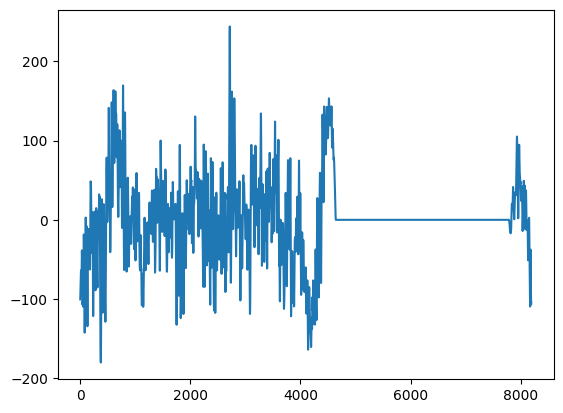

In [22]:
plt.plot(corr)

In [46]:
np.argmax(corr) / 8

np.float64(93.125)

In [40]:
np.argmax(corr) / 8

np.float64(61.875)

37 + 50 + ...

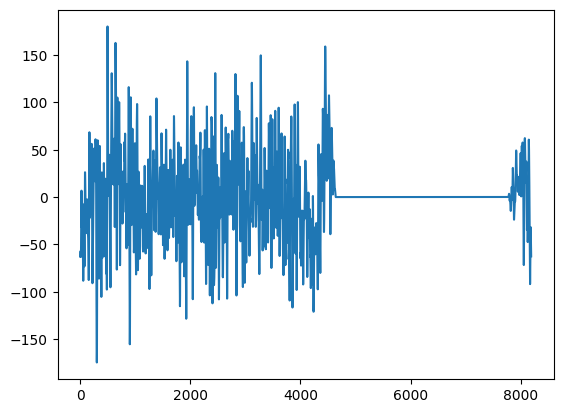

In [41]:
plt.plot(corr)

In [51]:
t = [i if i > 150 else 0 for i in corr]

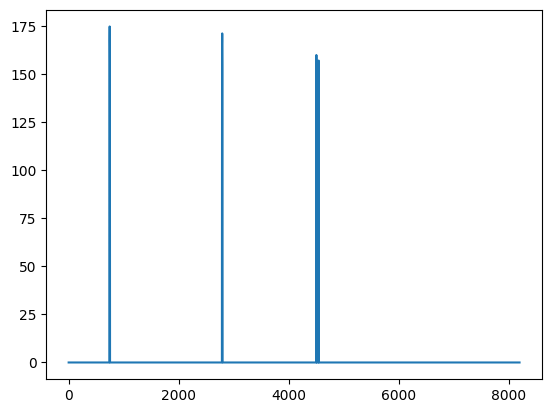

In [52]:
plt.plot(t)

In [216]:
best_shift = np.argmax(corr)
best_similarity = corr[best_shift]


In [217]:
best_shift

np.int64(3999)